In [8]:
import os
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

pd.set_option("display.width", 500)
np.printoptions("precision", 2)

In [12]:
hrv_fpath = "data/odsc_testdata_edited.csv"
df = pd.read_csv(hrv_fpath, encoding="utf-8", index_col="rawrrID")
df.head(3)

,rawRR
rawrrID,
0,843
1,882
2,914


### Preprocess Data for one user

In [53]:
def preprocess(user_df: pd.DataFrame, col: str="rawRR") -> pd.DataFrame:
    """Build a time vector from the RR or NN intervals.
    Build an instant HR column from the RR or NN intervals.
    """

    # Compute time in seconds, so that the first beat starts at 0 seconds
    firstHR = user_df[col].iloc[0] / 1000
    user_df["time"] = user_df[col].cumsum() / 1000 - firstHR

    # Compute instant HR from raw RR
    user_df["heartRate"] = np.divide(60000, user_df[col])
    return user_df

In [50]:
df = preprocess(df)
df.head(3)

,rawRR,time,heartRate
rawrrID,,,
0,843,0.000,71.174377
1,882,0.882,68.027211
2,914,1.796,65.645514


In [51]:
def plot_heartrate_colored_by_condition(user_df: pd.DataFrame) -> None:
    """Plot the time series of instant heart rate data"""
    time = user_df["time"]
    hr = user_df["heartRate"]

    # Segment the data by experimental condition
    # -- 1) HRVB following pacer
    # -- 2) Harder HRVB = HRVB following breath only while reading - i.e., a divided attentional challenge
    # -- 3) Breath of Fire (yogic fast breathing technique)
    # -- 4) Return to HRVB at the very end
    end_hrvb = time[time <= 2.25 * 60].shape[0]
    end_soundonly = time[time <= 3.25 * 60].shape[0]
    end_breath_of_fire = time[time <= 4.4 * 60].shape[0]
    
    # Plot the data - give each condition a separate color
    plt.figure(figsize=(18, 3))
    plt.plot(time[:end_hrvb], hr[:end_hrvb], color="navy")
    plt.plot(time[end_hrvb-1:end_soundonly], hr[end_hrvb-1:end_soundonly], color="teal")
    plt.plot(time[end_soundonly-1:end_breath_of_fire], hr[end_soundonly-1:end_breath_of_fire], color="crimson")
    plt.plot(time[end_breath_of_fire-1:], hr[end_breath_of_fire-1:], color="navy")
    
    plt.xlabel("Seconds", fontsize=14)
    plt.ylabel("Instant Heart Rate", fontsize=14)
    plt.title("Instant Heart Rate during HRVB and comparison conditions", fontsize=16)
    plt.show()

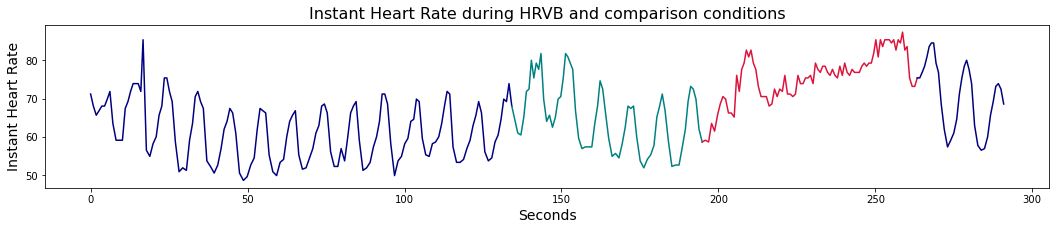

In [52]:
plot_heartrate_colored_by_condition(df)

In [86]:
def ectopic_removal(
        rr: np.ndarray, bounds: List[float]
    ) -> np.ndarray:
        """Remove ectopic beats from an rr interval series,
        using Aschbacher's modification of Kamath method.
        """
        assert 0 < bounds[0] < 1
        assert 1 < bounds[1]
        assert np.isnan(rr).sum() == 0

        # Initialize empty array for new rrs. First & last.
        nn = np.asarray([np.nan for i in range(rr.shape[0])])
        nn[0] = rr[0]
        nn[-2:] = rr[-2:]

        # We will use a window of length=3
        for i in range(0, len(rr) - 2):

            # Find the mean of the two outer points of the window
            w_mean = np.nanmean([rr[i], rr[i+2]])

            # Retain points that lie within the bounds around the mean, otherwise leave as np.nan
            if w_mean * bounds[0] < rr[i+1] < w_mean * bounds[1]:
                nn[i+1] = rr[i+1]
            else:
                print(f"nan'ed out index={i+1}")
        
        return nn

nan'ed out index=19
Number of beats removed = 1


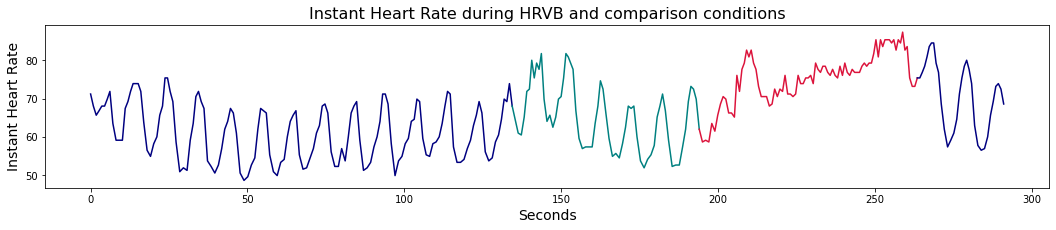

In [87]:
df["nn"] = ectopic_removal(df["rawRR"].values, bounds=[0.755, 1.25])
print(f"Number of beats removed = {df['nn'].isna().sum()}")

df["nn"] = df["nn"].interpolate(method="spline", order=3)
df = preprocess(df, col="nn")
plot_heartrate_colored_by_condition(df)